<h1 style="text-align: center;">Statistical Methods for Machine Learning</h1>
<h1 style="text-align: center;">"Cats and Dogs classification"</h1>

### Importing Libraries and Modules

In [2]:
import shutil
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Data folder preparation

This code cell organizes cat and dog images, creating a 'data' folder and renaming the files with a '0' (Cats) or '1' (Dogs) prefix.


In [1]:
data_path = r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\data'

# Creating the data folder if it doesn't already exist
if not os.path.exists(data_path):
    os.makedirs(data_path)

for filename in os.listdir(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\dogs'):
    if filename.endswith('.jpg'):
        shutil.copy(os.path.join(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\dogs', filename), os.path.join(data_path, '1' + filename))

for filename in os.listdir(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\cats'):
    if filename.endswith('.jpg'):
        shutil.copy(os.path.join(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\cats', filename), os.path.join(data_path, '0' + filename))


Checking if all the 25000 images have correctly populated the data folder.

In [3]:
data_dir = r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\data'

num_data = len([f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))])
print(f"There are {num_data} files in the folder {data_dir}")

There are 25000 files in the folder C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\data


### Loading, Preprocessing, and Splitting Data

Here I load and resize images to **150x150 pixels**, convert them to to NumPy arrays with **RGB channels**, **rescales** pixel values between 0 and 1, **shuffle** the images, and split the data into **train** and **test** sets.  

Two images are not loeaded because they were corrupted.


In [5]:
from sklearn.utils import shuffle

# Load the images and convert them to arrays
images = []
labels = []
for file in os.listdir(data_dir):
    if file.startswith('0'):
        label = 0  # cat
    else:
        label = 1  # dog
    try:
        img = load_img(os.path.join(data_dir, file), target_size=(150, 150))
    except:
        print("Cannot open image file:", file)
        continue
    img_array = img_to_array(img)
    img_array = img_array / 255.0  
    images.append(img_array)
    labels.append(label)

# Shuffle the images and labels
images, labels = shuffle(images, labels, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


Cannot open image file: 0666.jpg
Cannot open image file: 111702.jpg


Here I created the validation set by splitting the training set.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

### Inspecting the Data
Before feeding the data to the models, I check that the data has been preprocessed correctly.

In [7]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

14998
14998
5000
5000
5000
5000


In [8]:
print("Numero di immagini:", len(images))
print("Numero di etichette:", len(labels))

Numero di immagini: 24998
Numero di etichette: 24998


Display 16 random images

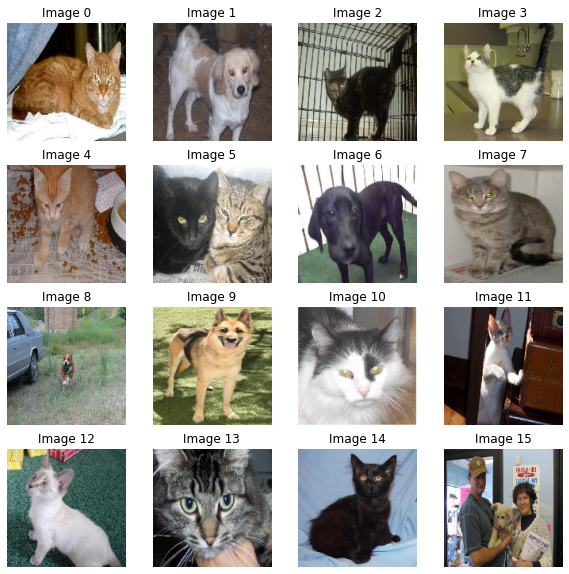

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

random_images = random.sample(images, 16)

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(random_images[i*4 + j])
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Image {i*4 + j}')

plt.show()


In [10]:
# Convert the lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


# Verify the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (14998, 150, 150, 3)
y_train shape: (14998,)
X_val shape: (5000, 150, 150, 3)
y_val shape: (5000,)
X_test shape: (5000, 150, 150, 3)
y_test shape: (5000,)


## 1st experiment: model1
`model1` is a very simple convolutional neural network (CNN). 

**Conv2D layers**: These are the convolutional layers that learn to extract features from the input images. The first layer has 32 filters, while the following layers have 64 and 128 filters. The filter size is (3, 3) for all layers, and the activation function used is 'relu', which introduces nonlinearity and helps the network learn more complex patterns.

**MaxPooling2D layers**: These layers perform downsampling, reducing the spatial dimensions of the feature maps. This helps reduce the number of parameters in the model and thus reduces computational cost, while also improving the model's ability to recognize features in different scales and translations.

**Flatten layer**: This layer reshapes the output of the previous MaxPooling2D layer into a one-dimensional tensor, so it can be fed into the dense layers.

**Dense layers**: These are fully connected layers that perform classification based on the extracted features. The first dense layer has 512 units with 'relu' activation. The last dense layer has only one unit with 'sigmoid' activation, which outputs the probability of the image being a dog (dog=1).

**Model compilation**: The model is compiled using the 'adam' optimizer, which is an adaptive learning rate optimization algorithm. It adjusts the learning rate during training, making it a popular choice for training neural networks. The loss function used is 'binary_crossentropy', which is suitable for binary classification problems (I will use zero-one loss only in the final cross validation). 

In [11]:
# Model architecture
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/20
469/469 [==============================] - 258s 542ms/step - loss: 0.6624 - accuracy: 0.5819 - val_loss: 0.6242 - val_accuracy: 0.6230
Epoch 2/20
469/469 [==============================] - 245s 523ms/step - loss: 0.5398 - accuracy: 0.7254 - val_loss: 0.4759 - val_accuracy: 0.7774
Epoch 3/20
469/469 [==============================] - 244s 521ms/step - loss: 0.4377 - accuracy: 0.7980 - val_loss: 0.4351 - val_accuracy: 0.7970
Epoch 4/20
469/469 [==============================] - 238s 508ms/step - loss: 0.3710 - accuracy: 0.8332 - val_loss: 0.3954 - val_accuracy: 0.8236
Epoch 5/20
469/469 [==============================] - 238s 507ms/step - loss: 0.2989 - accuracy: 0.8701 - val_loss: 0.3706 - val_accuracy: 0.8308
Epoch 6/20
469/469 [==============================] - 240s 511ms/step - loss: 0.2346 - accuracy: 0.9022 - val_loss: 0.3380 - val_accuracy: 0.8584
Epoch 7/20
469/469 [==============================] - 236s 503ms/step - loss: 0.1656 - accuracy: 0.9349 - val_loss: 0.3574 -

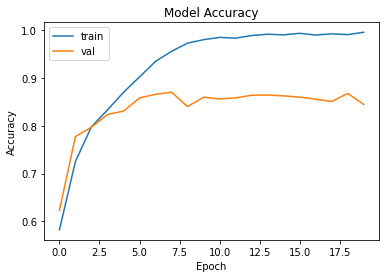

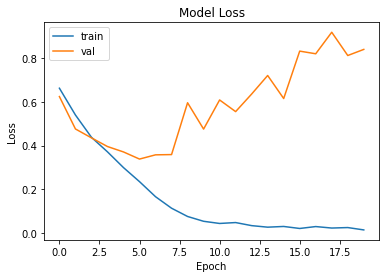

In [12]:
# Train the model
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Plot the training and validation accuracy over epochs
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Comments on model1 performances
The model demonstrates noticeable overfitting, as it reaches a high training accuracy of 99.59% but a significantly lower validation accuracy of 84.46%. The validation loss begins to increase after the 6th epoch, while the training loss continues to decrease, indicating that the model is fitting the training data too tightly and having difficulties generalizing to new, unseen data. To improve the model's performance on real-world data, it is essential to address the overfitting issue.

## 2nd experiment: model2
`model2` adds a Dropout layer, which combats overfitting by randomly disabling 50% of input units during training, encouraging the model to learn more generalizable features.

In [13]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  # Add dropout layer
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Epoch 1/20
469/469 [==============================] - 297s 624ms/step - loss: 0.6604 - accuracy: 0.5893 - val_loss: 0.6080 - val_accuracy: 0.6588
Epoch 2/20
469/469 [==============================] - 297s 632ms/step - loss: 0.5659 - accuracy: 0.7022 - val_loss: 0.5056 - val_accuracy: 0.7516
Epoch 3/20
469/469 [==============================] - 314s 669ms/step - loss: 0.4705 - accuracy: 0.7806 - val_loss: 0.4313 - val_accuracy: 0.8050
Epoch 4/20
469/469 [==============================] - 293s 625ms/step - loss: 0.3974 - accuracy: 0.8216 - val_loss: 0.4120 - val_accuracy: 0.8002
Epoch 5/20
469/469 [==============================] - 339s 723ms/step - loss: 0.3361 - accuracy: 0.8552 - val_loss: 0.3547 - val_accuracy: 0.8430
Epoch 6/20
469/469 [==============================] - 288s 613ms/step - loss: 0.2933 - accuracy: 0.8731 - val_loss: 0.2885 - val_accuracy: 0.8786
Epoch 7/20
469/469 [==============================] - 294s 627ms/step - loss: 0.2564 - accuracy: 0.8885 - val_loss: 0.2833 -

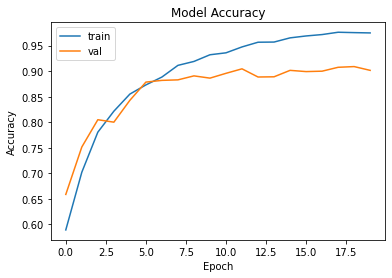

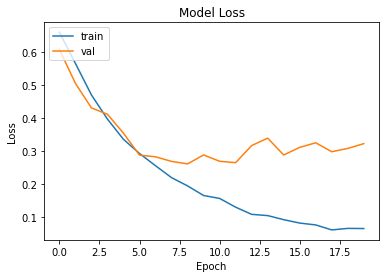

In [14]:
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comments on model2 performances
The second model achieves a lower training accuracy (97.49%) and validation accuracy (90.16%) compared to the first model. However, the smaller gap between the training and validation accuracies suggests a reduced overfitting issue. Although the model still exhibits some overfitting, it generalizes better to the validation dataset than the first model. The validation loss starts increasing after the 12th epoch, while the training loss keeps decreasing, indicating that there is still room for improvement in addressing overfitting.


## 3th experiment: model3
`model3` introduces several changes compared to the previous model:

1. **Additional Dropout layers**: In `model3`, Dropout layers are added after each Conv2D-MaxPooling2D block, with dropout rates of 10%, 20%, and 30% respectively. These additional Dropout layers help to further reduce overfitting by randomly disabling input units during training, which encourages the model to learn more generalizable features.

2. **Early Stopping**: An EarlyStopping callback is used during training, monitoring the validation loss with a patience of 3 epochs. This means that the training will stop if there is no improvement in validation loss for 3 consecutive epochs. The best weights, corresponding to the lowest validation loss, will be restored to the model at the end of training. 


In [15]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.1), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3), 
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



Epoch 1/25
469/469 [==============================] - 347s 738ms/step - loss: 0.6669 - accuracy: 0.5930 - val_loss: 0.5884 - val_accuracy: 0.6664
Epoch 2/25
469/469 [==============================] - 307s 654ms/step - loss: 0.5412 - accuracy: 0.7258 - val_loss: 0.4981 - val_accuracy: 0.7566
Epoch 3/25
469/469 [==============================] - 308s 657ms/step - loss: 0.4768 - accuracy: 0.7732 - val_loss: 0.4731 - val_accuracy: 0.7760
Epoch 4/25
469/469 [==============================] - 299s 638ms/step - loss: 0.4198 - accuracy: 0.8052 - val_loss: 0.4335 - val_accuracy: 0.8088
Epoch 5/25
469/469 [==============================] - 288s 615ms/step - loss: 0.3626 - accuracy: 0.8388 - val_loss: 0.4959 - val_accuracy: 0.7686
Epoch 6/25
469/469 [==============================] - 294s 628ms/step - loss: 0.3060 - accuracy: 0.8682 - val_loss: 0.4554 - val_accuracy: 0.8054
Epoch 7/25
469/469 [==============================] - 294s 627ms/step - loss: 0.2415 - accuracy: 0.8981 - val_loss: 0.4392 -

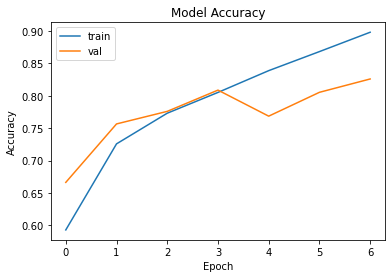

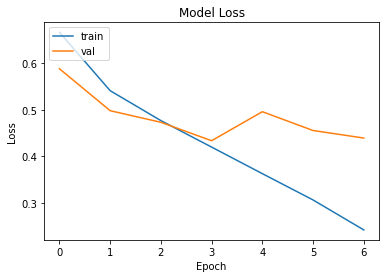

In [16]:
history3 = model3.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comments on model3 performances

`model3` reaches 89.81% training accuracy and 82.60% validation accuracy by the 7th epoch, with a smaller gap between them compared to previous models, suggesting reduced overfitting. However, the fluctuating validation loss and overall performance indicate possible underfitting, which may require further tuning of the model architecture and training parameters.


## 4th experiment: model4

The `model4` architecture introduces several changes compared to `model3`:

1. **Batch Normalization**: In this new model, Batch Normalization layers are added after each Conv2D layer and before the Dense layer. These layers help normalize the inputs to each layer, which can speed up the training process and improve generalization.

2. **Activation functions**: Instead of including the activation functions directly within the Conv2D and Dense layers, they are now separated into individual Activation layers. This allows Batch Normalization to be applied before the activation functions.

3. **Dropout rate**: The dropout rate has been changed to a constant value of 0.2 for all Dropout layers, which is a more moderate rate compared to the previous model. 

4. **Learning rate**: The learning rate for the Adam optimizer has been set to 0.0005, which is a smaller value compared to the default learning rate. This can help the model converge more steadily, potentially leading to better performance.


In [17]:
dropout_rate = 0.2
learning_rate = 0.0005

model4 = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model4.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



Epoch 1/25
469/469 [==============================] - 370s 786ms/step - loss: 0.6169 - accuracy: 0.6789 - val_loss: 0.7144 - val_accuracy: 0.5612
Epoch 2/25
469/469 [==============================] - 371s 790ms/step - loss: 0.4904 - accuracy: 0.7628 - val_loss: 0.5590 - val_accuracy: 0.7228
Epoch 3/25
469/469 [==============================] - 370s 789ms/step - loss: 0.4190 - accuracy: 0.8064 - val_loss: 0.4535 - val_accuracy: 0.7946
Epoch 4/25
469/469 [==============================] - 371s 790ms/step - loss: 0.3685 - accuracy: 0.8356 - val_loss: 0.4345 - val_accuracy: 0.8002
Epoch 5/25
469/469 [==============================] - 359s 765ms/step - loss: 0.3216 - accuracy: 0.8596 - val_loss: 0.4605 - val_accuracy: 0.8014
Epoch 6/25
469/469 [==============================] - 358s 763ms/step - loss: 0.2717 - accuracy: 0.8839 - val_loss: 0.6962 - val_accuracy: 0.7168
Epoch 7/25
469/469 [==============================] - 351s 749ms/step - loss: 0.2250 - accuracy: 0.9071 - val_loss: 0.4240 -

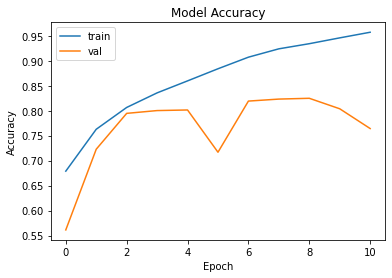

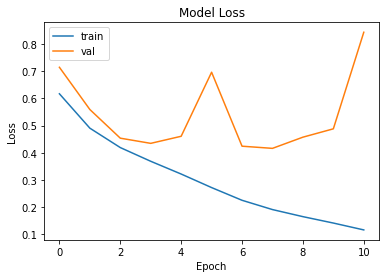

In [18]:
history4 = model4.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comments on model4 performances

`model4` shows improvement in learning from the training data with a training accuracy of 95.71% compared to Model3 (89.81%). However, it experiences again overfitting as evidenced by the increasing validation loss after epoch 7 and a significant difference between training and validation accuracy.

The highest validation accuracy achieved by Model4 is 82.48% at epoch 9, which is slightly lower than Model3's best validation accuracy of 82.60%.


## 5th experiment: model5
The `model5` introduces several modifications compared to the previous model:

1. **Reduced dropout rate**: The dropout rate is reduced to 0.1.
2. **L2 regularization**: L2 regularization (with a lambda of 0.001) is added to the convolutional and dense layers, which helps prevent overfitting by penalizing large weights in the model.
3. **Data augmentation**: The training data is augmented using rotation, width and height shifts, horizontal flips, and zoom. This increases the diversity of the training data and helps the model generalize better to unseen data.
4. **Increased dropout rate after third convolutional layer**: A higher dropout rate of 0.5 is applied after the third convolutional layer to reduce overfitting on deeper layers.


In [19]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train)

model5 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(512, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model5.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Epoch 1/25
468/468 [==============================] - 414s 882ms/step - loss: 1.5801 - accuracy: 0.6240 - val_loss: 1.1816 - val_accuracy: 0.6434
Epoch 2/25
468/468 [==============================] - 415s 887ms/step - loss: 1.0303 - accuracy: 0.6677 - val_loss: 0.8742 - val_accuracy: 0.7240
Epoch 3/25
468/468 [==============================] - 427s 912ms/step - loss: 0.8676 - accuracy: 0.6972 - val_loss: 1.0077 - val_accuracy: 0.6456
Epoch 4/25
468/468 [==============================] - 407s 868ms/step - loss: 0.8150 - accuracy: 0.7140 - val_loss: 0.8554 - val_accuracy: 0.7056
Epoch 5/25
468/468 [==============================] - 369s 789ms/step - loss: 0.7817 - accuracy: 0.7315 - val_loss: 0.7702 - val_accuracy: 0.7122
Epoch 6/25
468/468 [==============================] - 362s 773ms/step - loss: 0.7495 - accuracy: 0.7450 - val_loss: 0.7677 - val_accuracy: 0.7354
Epoch 7/25
468/468 [==============================] - 364s 777ms/step - loss: 0.7470 - accuracy: 0.7508 - val_loss: 0.6847 -

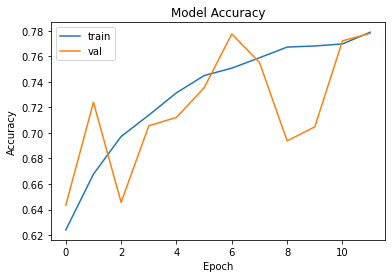

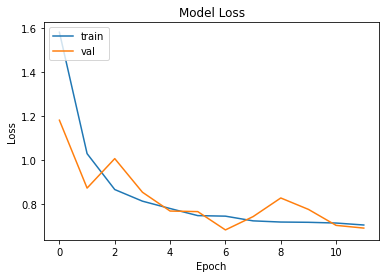

In [20]:
history5 = model5.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comments on model5 performances

The training loss decreases gradually, and the training accuracy increases to 77.89% in `model5`. However, the validation accuracy reaches its peak at 77.76% in epoch 7 and fluctuates afterward. The model doesn't seem to be overfitting, but its performance is bad.


## 6th experiment: model6

`model6` differs from the previous model by adding two more convolutional layers, making the architecture deeper. It also includes an additional Dense layer with 1024 units. These changes aim to improve the model's capacity to learn more complex and hierarchical features.


In [21]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train)

model6 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(512, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model6.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/25
468/468 [==============================] - 384s 816ms/step - loss: 3.0146 - accuracy: 0.6056 - val_loss: 2.7890 - val_accuracy: 0.5014
Epoch 2/25
468/468 [==============================] - 379s 810ms/step - loss: 2.0061 - accuracy: 0.6775 - val_loss: 1.5727 - val_accuracy: 0.7038
Epoch 3/25
468/468 [==============================] - 379s 809ms/step - loss: 1.2986 - accuracy: 0.7181 - val_loss: 1.1253 - val_accuracy: 0.7068
Epoch 4/25
468/468 [==============================] - 377s 806ms/step - loss: 0.9246 - accuracy: 0.7462 - val_loss: 0.8041 - val_accuracy: 0.7576
Epoch 5/25
468/468 [==============================] - 381s 814ms/step - loss: 0.7481 - accuracy: 0.7644 - val_loss: 0.6614 - val_accuracy: 0.7994
Epoch 6/25
468/468 [==============================] - 379s 810ms/step - loss: 0.6686 - accuracy: 0.7857 - val_loss: 0.5520 - val_accuracy: 0.8490
Epoch 7/25
468/468 [==============================] - 378s 807ms/step - loss: 0.6309 - accuracy: 0.8058 - val_loss: 0.6405 -

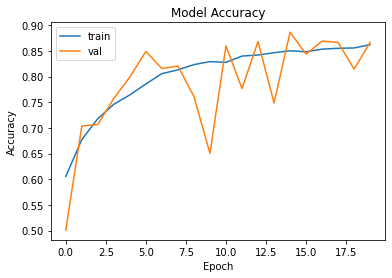

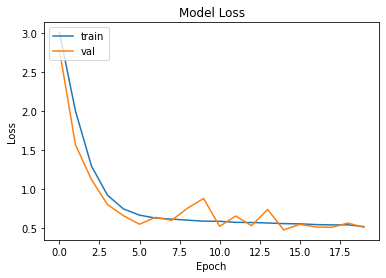

In [22]:
history6 = model6.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comments on model6 performances

`model6` achieved 88.64% validation accuracy at epoch 15, thanks to its deeper architecture and additional Dense layer. Training times were similar to previous models. However, fluctuations in validation accuracy and loss suggest the need for further fine-tuning or regularization techniques.


## 7th experiment: model7

`model7` introduces a `GlobalAveragePooling2D` layer instead of the `Flatten` layer used in the previous model. Global average pooling reduces the spatial dimensions of the feature maps by computing the average value of each channel, resulting in a smaller and more compact representation. This change helps reduce the total number of parameters, which can help prevent overfitting and improve training efficiency.


In [23]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train)

model7 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model7.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/25
468/468 [==============================] - 373s 795ms/step - loss: 1.7810 - accuracy: 0.6048 - val_loss: 1.5031 - val_accuracy: 0.5594
Epoch 2/25
468/468 [==============================] - 366s 782ms/step - loss: 1.2324 - accuracy: 0.6938 - val_loss: 1.0732 - val_accuracy: 0.6808
Epoch 3/25
468/468 [==============================] - 368s 786ms/step - loss: 0.9171 - accuracy: 0.7301 - val_loss: 0.8255 - val_accuracy: 0.7336
Epoch 4/25
468/468 [==============================] - 367s 785ms/step - loss: 0.7552 - accuracy: 0.7584 - val_loss: 1.5265 - val_accuracy: 0.5518
Epoch 5/25
468/468 [==============================] - 363s 774ms/step - loss: 0.6637 - accuracy: 0.7787 - val_loss: 0.6615 - val_accuracy: 0.7654
Epoch 6/25
468/468 [==============================] - 367s 783ms/step - loss: 0.6295 - accuracy: 0.7837 - val_loss: 1.3108 - val_accuracy: 0.5634
Epoch 7/25
468/468 [==============================] - 370s 790ms/step - loss: 0.5895 - accuracy: 0.7993 - val_loss: 0.5820 -

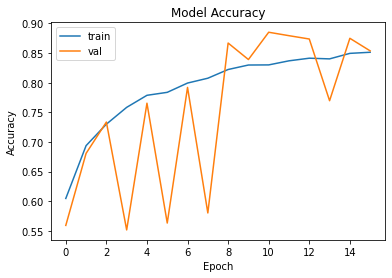

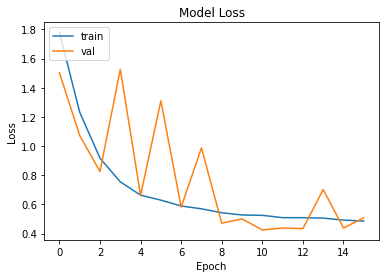

In [24]:
history7 = model7.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Comments on Model7 Performances

`model7` exhibits a steady improvement in validation accuracy, reaching its highest point at 88.50% in epoch 11. When compared to `model6`, which achieved a peak validation accuracy of 88.18% at epoch 12, model7 demonstrates a slightly better performance.

However, like `model6`, `model7` also experiences fluctuations in validation accuracy and loss, indicating potential benefits from further fine-tuning or additional regularization techniques for more stable performance.


## 8th experiment: model8

The `model8` introduces several changes compared to the previous one:

1. **Reduced dropout rate**: The dropout_rate is reduced to 0.1
2. **Lower learning rate**: The learning_rate is lowered to 0.0005, which may help the model converge more smoothly and find better local minima.
3. **L2 regularization**: L2 regularization is added to the convolutional and dense layers with a l2_lambda value of 0.001.
4. **Increased batch size**: The batch_size is increased to 64, which can provide a better estimate of the gradient and potentially accelerate training.

In [25]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train, batch_size=batch_size)

model8 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model8.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)


Epoch 1/25
234/234 [==============================] - 392s 2s/step - loss: 1.7986 - accuracy: 0.6209 - val_loss: 1.8794 - val_accuracy: 0.4958
Epoch 2/25
234/234 [==============================] - 388s 2s/step - loss: 1.1846 - accuracy: 0.7028 - val_loss: 1.1704 - val_accuracy: 0.5128
Epoch 3/25
234/234 [==============================] - 392s 2s/step - loss: 0.8749 - accuracy: 0.7380 - val_loss: 0.7534 - val_accuracy: 0.7970
Epoch 4/25
234/234 [==============================] - 982s 4s/step - loss: 0.7350 - accuracy: 0.7648 - val_loss: 0.6521 - val_accuracy: 0.7822
Epoch 5/25
234/234 [==============================] - 391s 2s/step - loss: 0.6519 - accuracy: 0.7821 - val_loss: 0.5643 - val_accuracy: 0.8356
Epoch 6/25
234/234 [==============================] - 448s 2s/step - loss: 0.6037 - accuracy: 0.7969 - val_loss: 0.8801 - val_accuracy: 0.6522
Epoch 7/25
234/234 [==============================] - 476s 2s/step - loss: 0.5753 - accuracy: 0.8055 - val_loss: 0.4634 - val_accuracy: 0.8696

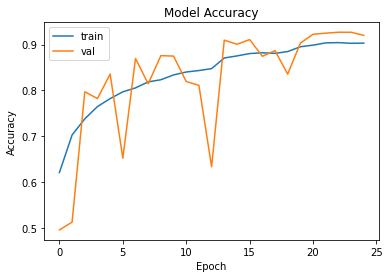

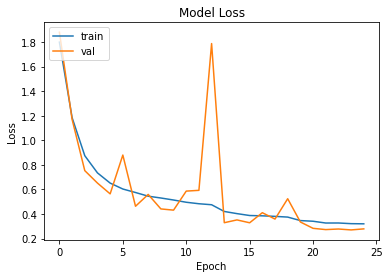

In [26]:
history8 = model8.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Comments on Model8 Performances

`model8` demonstrates a noticeable improvement over `model7`. The highest validation accuracy achieved by `model8` is 92.68% at epoch 23, compared to `model7`'s peak validation accuracy of 88.50% at epoch 11. 
Moreover, `model8` appears to have a more stable performance, with smaller fluctuations in validation accuracy and loss, compared to `model7`. This suggests that model8 has a better balance between learning capacity and generalization, leading to a more robust and accurate model.
However, I think that the model could do even better if trained for more epochs.


## 9th experiment: Model9
In `model9`, the number of epochs has been increased from 25 to 60, allowing the model more time to learn from the dataset. This change aims to explore whether additional training time could further improve the `model8`'s performance.

All other aspects of `model9` remain the same as in `model8`, including the architecture, L2 regularization, dropout rates, and data augmentation.


In [27]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train, batch_size=batch_size)

model9 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model9.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

Epoch 1/60
234/234 [==============================] - 366s 2s/step - loss: 1.7582 - accuracy: 0.6235 - val_loss: 1.4573 - val_accuracy: 0.4952
Epoch 2/60
234/234 [==============================] - 361s 2s/step - loss: 1.1381 - accuracy: 0.6980 - val_loss: 1.1473 - val_accuracy: 0.5020
Epoch 3/60
234/234 [==============================] - 363s 2s/step - loss: 0.8432 - accuracy: 0.7354 - val_loss: 0.8085 - val_accuracy: 0.6944
Epoch 4/60
234/234 [==============================] - 365s 2s/step - loss: 0.7050 - accuracy: 0.7632 - val_loss: 0.6903 - val_accuracy: 0.7264
Epoch 5/60
234/234 [==============================] - 370s 2s/step - loss: 0.6289 - accuracy: 0.7911 - val_loss: 1.2650 - val_accuracy: 0.6298
Epoch 6/60
234/234 [==============================] - 369s 2s/step - loss: 0.5929 - accuracy: 0.7992 - val_loss: 0.5268 - val_accuracy: 0.8308
Epoch 7/60
234/234 [==============================] - 365s 2s/step - loss: 0.5601 - accuracy: 0.8143 - val_loss: 0.6100 - val_accuracy: 0.7666

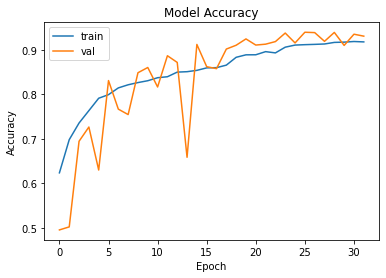

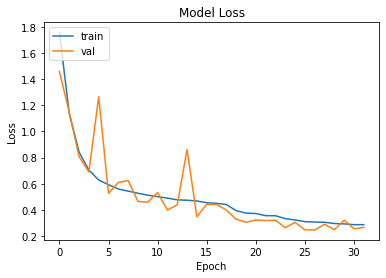

In [28]:
history9 = model9.fit(train_data, epochs=60, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comments on Model9 Performances
`model9` exhibits a promising overall performance concerning accuracy and loss. It reached a peak validation accuracy of 93.94% at epoch 26, indicating that extended training led to better results. In comparison to prior models, `model9` consistently displayed an increasing or relatively stable validation accuracy throughout the epochs. Its accuracy progressively improved over time without any evidence of overfitting.

## 10th experiment: model10
The `model10` introduces a few modifications compared to the previous `model9` to make it deeper:

1. **Additional convolutional layers**: The model10 incorporates an extra convolutional layer in the 64, 128, 256 filter sections, which could potentially help the model extract more complex features from the images.

In [31]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train, batch_size=batch_size)

model10 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model10.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)



Epoch 1/60
234/234 [==============================] - 657s 3s/step - loss: 2.1632 - accuracy: 0.5862 - val_loss: 1.6229 - val_accuracy: 0.4960
Epoch 2/60
234/234 [==============================] - 688s 3s/step - loss: 1.2599 - accuracy: 0.6539 - val_loss: 1.0331 - val_accuracy: 0.6502
Epoch 3/60
234/234 [==============================] - 698s 3s/step - loss: 0.9134 - accuracy: 0.7071 - val_loss: 0.8555 - val_accuracy: 0.6594
Epoch 4/60
234/234 [==============================] - 700s 3s/step - loss: 0.7624 - accuracy: 0.7359 - val_loss: 0.6648 - val_accuracy: 0.7878
Epoch 5/60
234/234 [==============================] - 732s 3s/step - loss: 0.6808 - accuracy: 0.7641 - val_loss: 0.7088 - val_accuracy: 0.7848
Epoch 6/60
234/234 [==============================] - 705s 3s/step - loss: 0.6270 - accuracy: 0.7829 - val_loss: 0.7057 - val_accuracy: 0.7546
Epoch 7/60
234/234 [==============================] - 775s 3s/step - loss: 0.5983 - accuracy: 0.7965 - val_loss: 0.6245 - val_accuracy: 0.7762

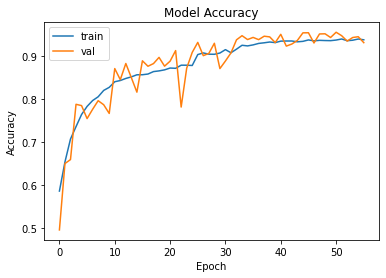

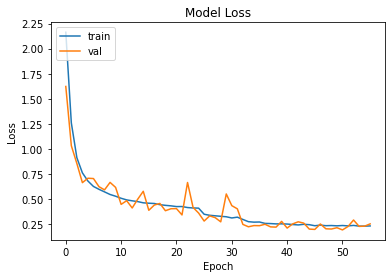

In [33]:
history10 = model10.fit(train_data, epochs=60, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Comments on Model10 Performances
`model10` stands out as the best model trained this far. It achieved a peak validation accuracy of 95.52% at epoch 51, indicating that the deeper architecture helped the model comprehend more complex features. Throughout the epochs, `model10` consistently displayed increasing or relatively stable validation accuracy. Its accuracy progressively improved over time without any indication of overfitting. However, the training time doubled compared to `model19` suggesting that achieving slightly higher performances will require a considerable amount of time and computational resources. Therefore, `model10` is a satisfying final model.

## Final model

After achieving a good level of accuracy and resolving the issues of overfitting and stability, we are ready to save the final model: Model10.

In [35]:
model10.save('C:/Users/lucad/OneDrive/Desktop/MACHINE LEARNING/models/model10.h5')

In [36]:
model10 = load_model('C:/Users/lucad/OneDrive/Desktop/MACHINE LEARNING/models/model10.h5')

### Test set accuracy
Let's evaluate the performance of the final model on the test set and analyze the types of images that were misclassified.

In [37]:
test_loss, test_acc = model10.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

157/157 [==============================] - 46s 287ms/step - loss: 0.1972 - accuracy: 0.9552
Test accuracy: 0.9552000164985657


The test accuracy seems to be pretty good for this task.

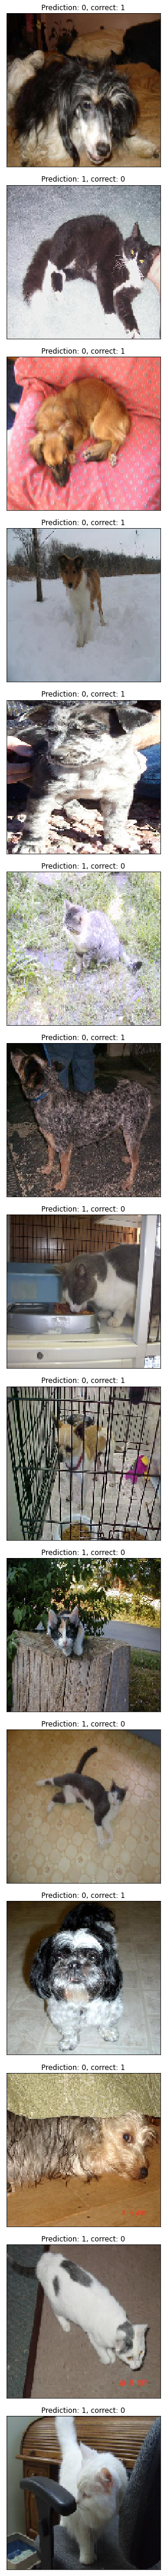

In [39]:
y_pred = model10.predict(X_test)

y_pred_labels = np.round(y_pred).astype(int).reshape(-1)

incorrect_indices = np.nonzero(y_pred_labels != y_test)[0]

n_show = min(len(incorrect_indices), 15)  
fig, axes = plt.subplots(n_show, 1, figsize=(8, 4 * n_show))

for i, incorrect_idx in enumerate(incorrect_indices[:n_show]):
    axes[i].imshow(X_test[incorrect_idx], cmap='gray', interpolation='none')
    axes[i].set_title("Prediction: {}, correct: {}".format(y_pred_labels[incorrect_idx], y_test[incorrect_idx]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.tight_layout()
plt.show()


We can observe that while some misclassified images were indeed challenging due to factors such as poor quality or unusual positions, others appeared to be easily classifiable. I think there is potential for improvement through the use of deeper CNN architectures and increased time and computational resources.

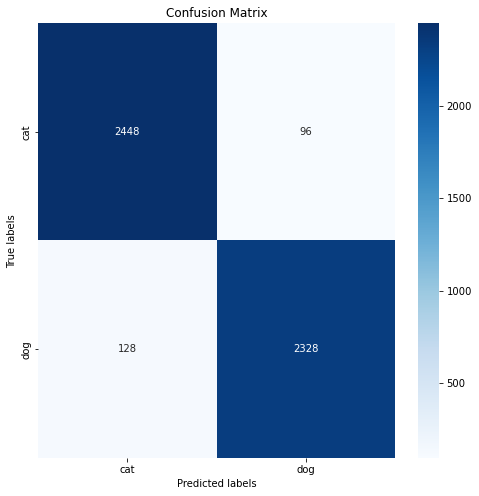

In [40]:
y_pred_labels = np.round(y_pred).astype(int).reshape(-1)
conf_mat = confusion_matrix(y_test, y_pred_labels)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


The confusion matrix shows that the proportion of misclassified dog and misclassified cats is very similar indicating that our model is pretty balanced.

### Let's test it on friends' pets
Here I load the images of some friends' cats and dogs, including my own cat Milton.

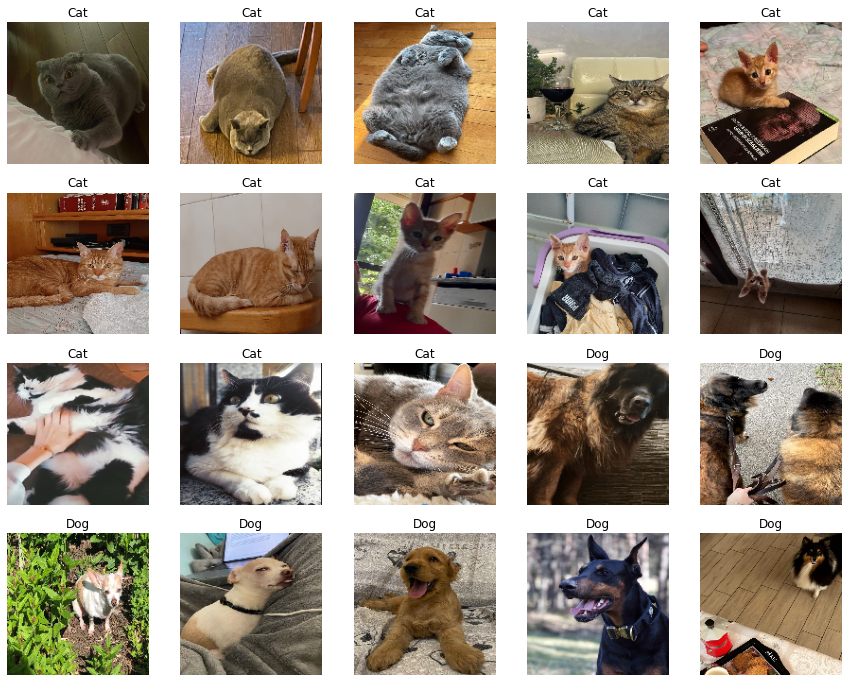

In [41]:
new_images_dir = r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\new images'

new_images = []
new_labels = []
for new_file in os.listdir(new_images_dir):
    if new_file.startswith('0'):
        label = 0  # cat
    else:
        label = 1  # dog
    try:
        new_img = load_img(os.path.join(new_images_dir, new_file), target_size=(150, 150))
    except:
        print("Cannot open image file:", file)
        continue
    new_img_array = img_to_array(new_img)
    new_img_array = new_img_array / 255.0  
    new_images.append(new_img_array)
    new_labels.append(label)

new_images = np.array(new_images)
new_labels = np.array(new_labels)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(new_images[index])
        axs[i, j].axis('off')
        if new_labels[index] == 0:
            axs[i, j].set_title('Cat')
        else:
            axs[i, j].set_title('Dog')
        if index == len(new_images) - 1:
            break
plt.show()



Let's classify them!

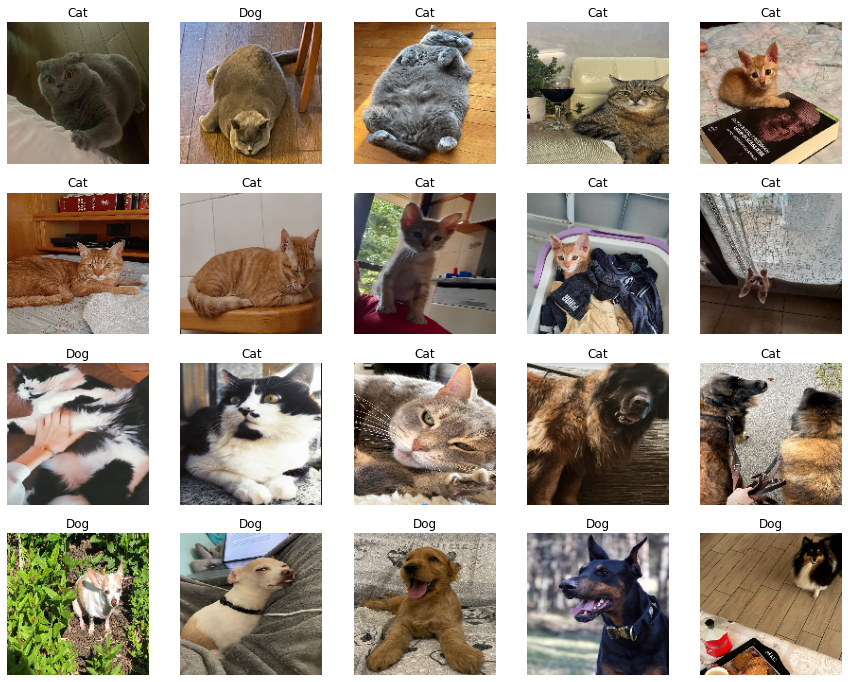

In [42]:
new_predictions = model10.predict(new_images)

num_images = len(new_images)
num_cols = 5
num_rows = num_images // num_cols + (1 if num_images % num_cols != 0 else 0)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index >= num_images:
            break
        axs[i, j].imshow(new_images[index])
        axs[i, j].axis('off')
        if new_predictions[index] < 0.5:
            axs[i, j].set_title('Cat')
        else:
            axs[i, j].set_title('Dog')
plt.show()



There are four mistakes. It seems I provided more challenging images!

## Cross validation
Finally, to compute our risk estimates for the final model, we used 5-fold cross-validation with the zero-one loss (as required). Model10 was recreated identically, including early stopping and data augmentation.

For each fold, the data was split into training and validation sets, and the model was trained on the training set while monitoring the validation loss. The model was then used to predict the validation labels, and the zero-one loss was calculated as the percentage of misclassified images. This process was repeated for all five folds, and the mean zero-one loss across all folds was calculated as our final risk estimate.

In [43]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train, batch_size=batch_size)

model10_CV = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])


model10_CV.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)


In [44]:
# Combine train and validation data
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

# Divide the combined data into 5 folds
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

zero_one_losses = []

fold_counter = 1

for train_index, val_index in kfold.split(X_combined, y_combined):
    print(f"Training Fold {fold_counter} of {n_folds}...")
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]

    train_data = train_datagen.flow(X_train_fold, y_train_fold, batch_size=batch_size)

    history10_CV = model10_CV.fit(train_data, epochs=60, steps_per_epoch=len(X_train_fold) // batch_size, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping, lr_scheduler], verbose=1)

    y_val_pred = model10_CV.predict(X_val_fold)
    y_val_pred = np.round(y_val_pred).flatten()

    zero_one_loss = 1 - accuracy_score(y_val_fold, y_val_pred)
    zero_one_losses.append(zero_one_loss)
    print(f"Fold {fold_counter} Zero-One Loss: {zero_one_loss:.4f}")

    fold_counter += 1

# Calculate the average zero-one loss across all folds
mean_zero_one_loss = np.mean(zero_one_losses)
print(f"Mean Zero-One Loss: {mean_zero_one_loss:.4f}")



Training Fold 1 of 5...
Epoch 1/60
249/249 [==============================] - 708s 3s/step - loss: 2.1839 - accuracy: 0.5725 - val_loss: 1.8158 - val_accuracy: 0.4995
Epoch 2/60
249/249 [==============================] - 662s 3s/step - loss: 1.2514 - accuracy: 0.6383 - val_loss: 1.2193 - val_accuracy: 0.5390
Epoch 3/60
249/249 [==============================] - 707s 3s/step - loss: 0.8893 - accuracy: 0.6973 - val_loss: 0.8188 - val_accuracy: 0.7283
Epoch 4/60
249/249 [==============================] - 746s 3s/step - loss: 0.7523 - accuracy: 0.7274 - val_loss: 1.0107 - val_accuracy: 0.5617
Epoch 5/60
249/249 [==============================] - 738s 3s/step - loss: 0.6711 - accuracy: 0.7522 - val_loss: 0.9407 - val_accuracy: 0.6283
Epoch 6/60
249/249 [==============================] - 736s 3s/step - loss: 0.6288 - accuracy: 0.7777 - val_loss: 0.5694 - val_accuracy: 0.8120
Epoch 7/60
249/249 [==============================] - 773s 3s/step - loss: 0.5946 - accuracy: 0.7889 - val_loss: 0.576

The risk estimates for the final model using 5-fold cross-validation with the zero-one loss is 0.0436. I think it is a satisfactory result!